# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [32]:
import random
import numpy as np
import pandas as pd
import re
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [2]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for your interests.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [3]:
from cs231n.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [45]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM

lr_min = 5e-9
lr_max = 2e-8
learning_rates = sorted(list(lr_min + np.random.ranf(10) * (lr_max - lr_min)))
regularization_strengths = sorted(list(np.random.randint(low=1e5, high=9e6, size=10)))
print(['{:.2e}'.format(x) for x in learning_rates])
print(['{:.2e}'.format(x) for x in regularization_strengths])

results = {}
best_val = -1
best_svm = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
num_iters = 5000
for lr in learning_rates:
    for reg in regularization_strengths:
        svm = LinearSVM()
        loss_hist = svm.train(X_train_feats, y_train, learning_rate=lr, reg=reg,
                              num_iters=num_iters, verbose=False)
        y_train_pred = svm.predict(X_train_feats)
        train_acc = np.mean(y_train == y_train_pred)
        y_val_pred = svm.predict(X_val_feats)
        val_acc = np.mean(y_val == y_val_pred)
        results[(lr, reg)] = (train_acc, val_acc)
        if val_acc > best_val:
            best_val = val_acc
            best_svm = svm
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

['5.05e-09', '5.19e-09', '6.17e-09', '7.63e-09', '1.52e-08', '1.62e-08', '1.66e-08', '1.67e-08', '1.96e-08', '1.99e-08']
['5.25e+05', '6.14e+05', '7.21e+05', '3.15e+06', '3.30e+06', '3.78e+06', '4.44e+06', '5.37e+06', '7.62e+06', '8.08e+06']
lr 5.050768e-09 reg 5.253700e+05 train accuracy: 0.413612 val accuracy: 0.417000
lr 5.050768e-09 reg 6.136210e+05 train accuracy: 0.416327 val accuracy: 0.428000
lr 5.050768e-09 reg 7.207330e+05 train accuracy: 0.412449 val accuracy: 0.416000
lr 5.050768e-09 reg 3.152085e+06 train accuracy: 0.412633 val accuracy: 0.414000
lr 5.050768e-09 reg 3.304042e+06 train accuracy: 0.415184 val accuracy: 0.404000
lr 5.050768e-09 reg 3.784241e+06 train accuracy: 0.419306 val accuracy: 0.429000
lr 5.050768e-09 reg 4.438802e+06 train accuracy: 0.410245 val accuracy: 0.404000
lr 5.050768e-09 reg 5.366537e+06 train accuracy: 0.404020 val accuracy: 0.402000
lr 5.050768e-09 reg 7.621928e+06 train accuracy: 0.408082 val accuracy: 0.414000
lr 5.050768e-09 reg 8.076835e

In [60]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.428


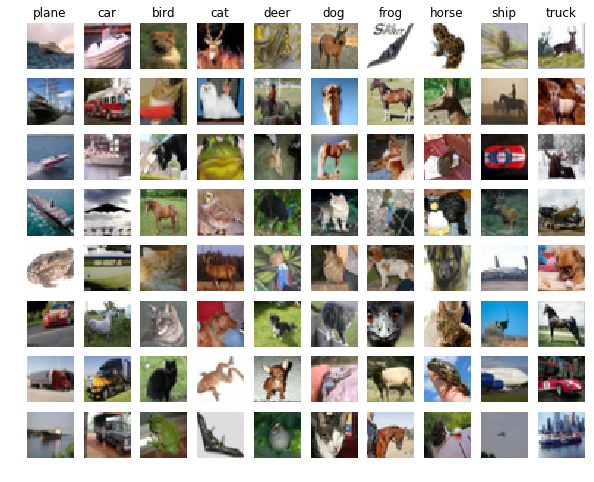

In [61]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?

They make sense in light of the fact that we are using color histograms as features (e.g., grey object with sky-blue background misclassified as airplane).

## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [4]:
# Preprocessing: Remove the bias dimension
# Make sure to run this cell only ONCE
print(X_train_feats.shape)
X_train_feats = X_train_feats[:, :-1]
X_val_feats = X_val_feats[:, :-1]
X_test_feats = X_test_feats[:, :-1]

print(X_train_feats.shape)

(49000, 155)
(49000, 154)


In [67]:
from cs231n.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]
#hidden_dim = 500
num_classes = 10

#net = TwoLayerNet(input_dim, hidden_dim, num_classes)
best_net = None

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
np.random.seed(2018)

min_lr = 0.5
max_lr = 2.0
learning_rates = sorted(list(min_lr + np.random.ranf(5) * (max_lr - min_lr)))
print('Learning rates:', learning_rates)

reg = sorted(list(0.01 * np.random.ranf(5)))
print('Regularizaion:', reg)

num_iters = 1000

learning_rate_decay = [0.5, 0.75, 0.95]

hidden_dim = [100, 500, 1000]

nets = {}
stats = {}
val_acc = {}

num_combinations = len(learning_rates) * len(reg) * len(learning_rate_decay) * len(hidden_dim)

for lr in learning_rates:
    print('lr: ', lr)
    for r in reg:
        print('  reg: ', r)
        for lrd in learning_rate_decay:
            print('    lr decay: ', lrd)
            for h in hidden_dim:
                print('      hidden dim: ', h)
                key = 'lr_' + str(lr) + '_reg_' + str(r) + '_lrd_' + str(lrd) + '_h_' + str(h)
                nets[key] = TwoLayerNet(input_dim, h, num_classes)
                stats[key] = nets[key].train(X_train_feats, y_train, X_val_feats, y_val,
                            num_iters=num_iters, batch_size=200,
                            learning_rate=lr, learning_rate_decay=lrd,
                            reg=r, verbose=False)
                val_acc[key] = (nets[key].predict(X_val_feats) == y_val).mean()
                print('\t\t~~>Validation accuracy: ', val_acc[key])
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

Learning rates: [0.6564916067907165, 0.9595983479095272, 1.169613308641133, 1.823523967630919, 1.8605140002745109]
Regularizaion: [0.0010721507886022818, 0.005899853915235484, 0.006978006071533108, 0.008028028375301016, 0.00837111099476273]
lr:  0.6564916067907165
  reg:  0.0010721507886022818
    lr decay:  0.5
      hidden dim:  100
		~~>Validation accuracy:  0.526
      hidden dim:  500
		~~>Validation accuracy:  0.535
      hidden dim:  1000
		~~>Validation accuracy:  0.524
    lr decay:  0.75
      hidden dim:  100
		~~>Validation accuracy:  0.555
      hidden dim:  500
		~~>Validation accuracy:  0.575
      hidden dim:  1000
		~~>Validation accuracy:  0.584
    lr decay:  0.95
      hidden dim:  100
		~~>Validation accuracy:  0.567
      hidden dim:  500
		~~>Validation accuracy:  0.569
      hidden dim:  1000
		~~>Validation accuracy:  0.548
  reg:  0.005899853915235484
    lr decay:  0.5
      hidden dim:  100
		~~>Validation accuracy:  0.516
      hidden dim:  500
		~~>Validat

		~~>Validation accuracy:  0.516
    lr decay:  0.75
      hidden dim:  100
		~~>Validation accuracy:  0.503
      hidden dim:  500
		~~>Validation accuracy:  0.514
      hidden dim:  1000
		~~>Validation accuracy:  0.521
    lr decay:  0.95
      hidden dim:  100
		~~>Validation accuracy:  0.462
      hidden dim:  500
		~~>Validation accuracy:  0.47
      hidden dim:  1000
		~~>Validation accuracy:  0.494
  reg:  0.00837111099476273
    lr decay:  0.5
      hidden dim:  100
		~~>Validation accuracy:  0.511
      hidden dim:  500
		~~>Validation accuracy:  0.518
      hidden dim:  1000
		~~>Validation accuracy:  0.509
    lr decay:  0.75
      hidden dim:  100
		~~>Validation accuracy:  0.509
      hidden dim:  500
		~~>Validation accuracy:  0.536
      hidden dim:  1000
		~~>Validation accuracy:  0.52
    lr decay:  0.95
      hidden dim:  100
		~~>Validation accuracy:  0.485
      hidden dim:  500
		~~>Validation accuracy:  0.488
      hidden dim:  1000
		~~>Validation accuracy:  0.5

In [68]:
# my code: investigate the changes in accuracy w.r.t. different hyper parameters
results = pd.Series(val_acc).reset_index(name='val_acc')
params = [re.sub(r'[a-z]+_', '', i) for i in list(results['index'])]
params = [re.split('_+', p) for p in params]
params = [[float(x) for x in row] for row in params]
col_names = re.split(r'[_.0-9]+', list(val_acc.keys())[0])
print(col_names)
col_names = list(filter(None, col_names))
results_df = pd.DataFrame(params, columns=col_names)
results_df = pd.concat([results, results_df], axis=1)
print(results_df.shape)
results_df.head()

['lr', 'reg', 'lrd', 'h', '']
(225, 6)


index  val_acc        lr  \
0  lr_0.6564916067907165_reg_0.001072150788602281...    0.526  0.656492   
1  lr_0.6564916067907165_reg_0.001072150788602281...    0.524  0.656492   
2  lr_0.6564916067907165_reg_0.001072150788602281...    0.535  0.656492   
3  lr_0.6564916067907165_reg_0.001072150788602281...    0.555  0.656492   
4  lr_0.6564916067907165_reg_0.001072150788602281...    0.584  0.656492   

        reg   lrd       h  
0  0.001072  0.50   100.0  
1  0.001072  0.50  1000.0  
2  0.001072  0.50   500.0  
3  0.001072  0.75   100.0  
4  0.001072  0.75  1000.0

In [70]:
# my code: investigate the changes in accuracy w.r.t. different hyper parameters
print('Best overall:')
print(results_df.loc[results_df['val_acc'] == results_df['val_acc'].max(), ['val_acc'] + col_names])
print('---\nValidation accuracy by learning rate:')
print(results_df.loc[:, ['lr', 'val_acc']].groupby('lr').mean())
print('---\nValidation accuracy by regularization:')
print(results_df.loc[:, ['reg', 'val_acc']].groupby('reg').mean())
print('---\nValidation accuracy by learning rate decay:')
print(results_df.loc[:, ['lrd', 'val_acc']].groupby('lrd').mean())
print('---\nValidation accuracy by number of hidden units:')
print(results_df.loc[:, ['h', 'val_acc']].groupby('h').mean())

Best overall:
     val_acc        lr       reg   lrd       h
184      0.6  1.860514  0.001072  0.75  1000.0
---
Validation accuracy by learning rate:
           val_acc
lr                
0.656492  0.525556
0.959598  0.525778
1.169613  0.524000
1.823524  0.522489
1.860514  0.520400
---
Validation accuracy by regularization:
           val_acc
reg               
0.001072  0.563600
0.005900  0.524489
0.006978  0.517622
0.008028  0.507578
0.008371  0.504933
---
Validation accuracy by learning rate decay:
       val_acc
lrd           
0.50  0.531360
0.75  0.536253
0.95  0.503320
---
Validation accuracy by number of hidden units:
         val_acc
h               
100.0   0.520373
500.0   0.525360
1000.0  0.525200


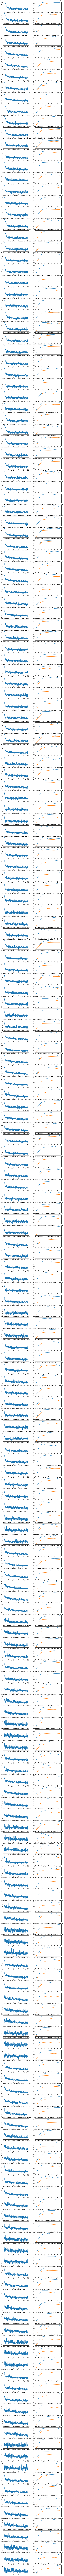

In [71]:
# my code: Plot the loss function and train / validation accuracies

fig, m_axs = plt.subplots(num_combinations, 2, figsize=(15, num_combinations * 3))
for (ax1, ax2), params in zip(m_axs, stats.keys()):
    ax1.plot(stats[params]['loss_history'])
    ax1.set_title(params)
    ax2.plot(stats[params]['train_acc_history'], label='train')
    ax2.plot(stats[params]['val_acc_history'], label='val')
    ax2.set_title(params)

In [73]:
# my code

best_net_key = max(val_acc, key=val_acc.get)
best_net = nets[best_net_key]

best_val_acc = (best_net.predict(X_val_feats) == y_val).mean()
print('Validation accuracy: ', best_val_acc)

Validation accuracy:  0.6


iteration 0 / 3000: loss 1.163454
iteration 100 / 3000: loss 1.254736
iteration 200 / 3000: loss 1.154686
iteration 300 / 3000: loss 1.117082
iteration 400 / 3000: loss 1.065860
iteration 500 / 3000: loss 1.008284
iteration 600 / 3000: loss 1.132855
iteration 700 / 3000: loss 1.123701
iteration 800 / 3000: loss 1.117909
iteration 900 / 3000: loss 1.046580
iteration 1000 / 3000: loss 1.047520
iteration 1100 / 3000: loss 1.074484
iteration 1200 / 3000: loss 1.030535
iteration 1300 / 3000: loss 1.034756
iteration 1400 / 3000: loss 0.987858
iteration 1500 / 3000: loss 1.005707
iteration 1600 / 3000: loss 1.006759
iteration 1700 / 3000: loss 0.979957
iteration 1800 / 3000: loss 0.997436
iteration 1900 / 3000: loss 0.961892
iteration 2000 / 3000: loss 1.015759
iteration 2100 / 3000: loss 0.908597
iteration 2200 / 3000: loss 0.956893
iteration 2300 / 3000: loss 0.922815
iteration 2400 / 3000: loss 1.073274
iteration 2500 / 3000: loss 0.909390
iteration 2600 / 3000: loss 1.018972
iteration 270

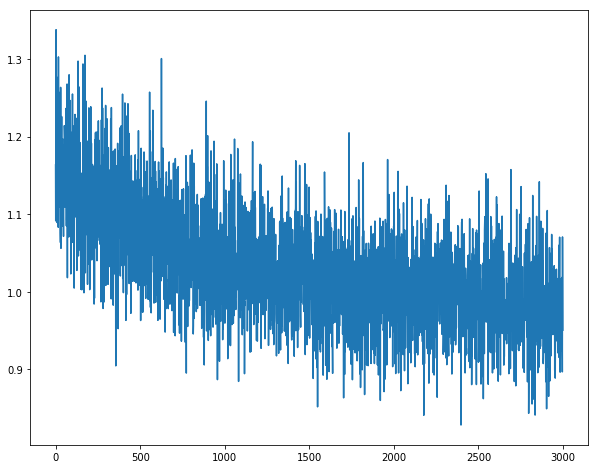

In [80]:
# my code: train the best model some more
import copy

best_net_copy = copy.deepcopy(best_net)
loss_hist = best_net_copy.train(X_train_feats, y_train, X_val_feats, y_val,
                num_iters=3000, batch_size=200,
                learning_rate=0.5, learning_rate_decay=0.75,
                reg=0.001072, verbose=True)

plt.plot(loss_hist['loss_history'])

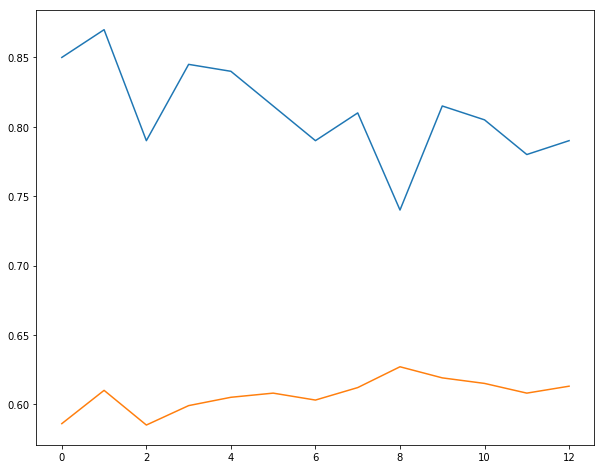

In [84]:
plt.plot(loss_hist['train_acc_history'])
plt.plot(loss_hist['val_acc_history'])

In [85]:
# Run your best neural net classifier on the test set. You should be able
# to get more than 55% accuracy.

test_acc = (best_net_copy.predict(X_test_feats) == y_test).mean()
print(test_acc)

0.615
